# Explanation:

## Score: 0.45196
The target variable is: 

amount_new_house_transactions: The total monetary value of new house transactions in 10,000 yuan.

We are using some of the features found in the different csv's to predict the final amount
The method used is XGBoost with cross validation

# 1. SETUP - Dependencies, dataloading

## 1.1 Dependencies and plotting style

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import sys
import sklearn
import xgboost as xgb
import optuna

from dateutil.relativedelta import relativedelta
from xgboost.callback import EarlyStopping
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from pathlib import Path
from datetime import datetime

In [2]:
# Set global plot styles
plt.rc('font', size=12)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=12)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

## 1.2 Loads all necessary data without any processing

We first define the datapath

In [3]:
# Define the data path
DATA_PATH = Path("/Users/nikola/Python/KaggleCompetition/data")

We load the complemetary datasets which will include many of the features

In [4]:
# Transaction Data (Monthly)
new_house = pd.read_csv(DATA_PATH / "train" / "new_house_transactions.csv")
pre_owned = pd.read_csv(DATA_PATH / "train" / "pre_owned_house_transactions.csv")
land = pd.read_csv(DATA_PATH / "train" / "land_transactions.csv")

# Nearby Sectors Transaction Data
new_house_nearby = pd.read_csv(DATA_PATH / "train" / "new_house_transactions_nearby_sectors.csv")
pre_owned_nearby = pd.read_csv(DATA_PATH / "train" / "pre_owned_house_transactions_nearby_sectors.csv")
land_nearby = pd.read_csv(DATA_PATH / "train" / "land_transactions_nearby_sectors.csv")

# Sector Features (Static)
sector_poi = pd.read_csv(DATA_PATH / "train" / "sector_POI.csv")

# Market Indicators (Time-series)
search_index = pd.read_csv(DATA_PATH / "train" / "city_search_index.csv")
city_indexes = pd.read_csv(DATA_PATH / "train" / "city_indexes.csv")

# Convert month columns to datetime for datasets that have it
datasets_with_month = [new_house, pre_owned, land, new_house_nearby, pre_owned_nearby, land_nearby, search_index]

for df in datasets_with_month:
    if 'month' in df.columns:
        df['month'] = pd.to_datetime(df['month'])

# Store in dictionary for easy access
datasets = {
    'new_house': new_house,
    'pre_owned': pre_owned,
    'land': land,
    'new_house_nearby': new_house_nearby,
    'pre_owned_nearby': pre_owned_nearby,
    'land_nearby': land_nearby,
    'sector_poi': sector_poi,
    'search_index': search_index,
    'city_indexes': city_indexes
}

/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_37513/712092853.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_37513/712092853.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_37513/712092853.py:23: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['month'] = pd.to_datetime(df['month'])
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_37513/71209

In [5]:
new_house.tail()

,month,sector,num_new_house_transactions,area_new_house_transactions,price_new_house_transactions,amount_new_house_transactions,area_per_unit_new_house_transactions,total_price_per_unit_new_house_transactions,num_new_house_available_for_sale,area_new_house_available_for_sale,period_new_house_sell_through
5428,2024-07-01,sector 91,70,7921,40967,32450.06,113,463.57,2133.0,341192.0,51.82
5429,2024-07-01,sector 92,211,22084,13949,30804.74,105,145.99,5908.0,636696.0,34.76
5430,2024-07-01,sector 93,62,8136,27452,22335.30,131,360.25,1323.0,150862.0,27.74
5431,2024-07-01,sector 94,44,5078,26367,13389.41,115,304.30,2027.0,215821.0,38.62
5432,2024-07-01,sector 96,1,140,40079,561.19,140,561.19,1.0,195.0,1.39


# 2. DATA & FEATURE ENGINEERING - Merging, cleaning, handling missing values


In [11]:
# ------------------------------------------
# 3.1 Create Master Dataset - Selected Features Only
# ------------------------------------------

# Start with new_house as base (contains target)
df = new_house.copy()

# Define target variable
target_col = 'amount_new_house_transactions'

# Define exactly which columns to merge from each dataset
columns_to_merge = {
    'pre_owned': [
        'month', 'sector',
        'area_pre_owned_house_transactions',
        'amount_pre_owned_house_transactions',
        'num_pre_owned_house_transactions',
        'price_pre_owned_house_transactions'
    ],
    'land': [
        'month', 'sector',
        'num_land_transactions',
        'planned_building_area',
        'transaction_amount'
    ],
    'new_house_nearby': [
        'month', 'sector',
        'num_new_house_transactions_nearby_sectors',
        'area_new_house_transactions_nearby_sectors',
        'amount_new_house_transactions_nearby_sectors',
        'price_new_house_transactions_nearby_sectors'
    ],
    'pre_owned_nearby': [
        'month', 'sector',
        'num_pre_owned_house_transactions_nearby_sectors',
        'amount_pre_owned_house_transactions_nearby_sectors',
        'price_pre_owned_house_transactions_nearby_sectors'
    ],
    'land_nearby': [
        'month', 'sector',
        'num_land_transactions_nearby_sectors',
        'planned_building_area_nearby_sectors',
        'transaction_amount_nearby_sectors'
    ]
}

# Merge each dataset with specific columns
for data, name in [(pre_owned, 'pre_owned'), (land, 'land'), 
                   (new_house_nearby, 'new_house_nearby'),
                   (pre_owned_nearby, 'pre_owned_nearby'),
                   (land_nearby, 'land_nearby')]:
    
    # Get columns that exist in the dataset
    cols_to_use = [col for col in columns_to_merge[name] if col in data.columns]
    
    # Merge
    df = df.merge(data[cols_to_use], on=['month', 'sector'], how='left')
    print(f"Merged {name}: added {len(cols_to_use)-2} features, shape: {df.shape}")

print(f"\nFinal dataset shape: {df.shape}")
print(f"Total features (excluding target): {df.shape[1] - 1}")

Merged pre_owned: added 4 features, shape: (5433, 16)
Merged land: added 3 features, shape: (5433, 19)
Merged new_house_nearby: added 4 features, shape: (5433, 23)
Merged pre_owned_nearby: added 3 features, shape: (5433, 26)
Merged land_nearby: added 3 features, shape: (5433, 29)

Final dataset shape: (5433, 29)
Total features (excluding target): 28


In [12]:
# ------------------------------------------
# 3.2 Create Time Features
# ------------------------------------------

df['date'] = pd.to_datetime(df['month'])
df['month_num'] = df['date'].dt.month
df['quarter'] = df['date'].dt.quarter
df['year'] = df['date'].dt.year
df['days_in_month'] = df['date'].dt.days_in_month

# Cyclical encoding for month
df['month_sin'] = np.sin(2 * np.pi * df['month_num'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month_num'] / 12)

In [13]:
# ------------------------------------------
# 3.3 Create Lag Features
# ------------------------------------------

# Sort by sector and date for proper lag calculation
df = df.sort_values(['sector', 'date'])

# Target lags
target_col = 'amount_new_house_transactions'
lag_periods = [1, 2, 3, 6, 12]

for lag in lag_periods:
    df[f'{target_col}_lag_{lag}'] = df.groupby('sector')[target_col].shift(lag)

# Rolling statistics for target
rolling_windows = [3, 6, 12]
for window in rolling_windows:
    df[f'{target_col}_rolling_mean_{window}'] = (
        df.groupby('sector')[target_col]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
    )
    df[f'{target_col}_rolling_std_{window}'] = (
        df.groupby('sector')[target_col]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).std())
    )

# Price momentum features
if 'price_new_house_transactions' in df.columns:
    for lag in [1, 3, 6]:
        df[f'price_change_{lag}m'] = (
            df.groupby('sector')['price_new_house_transactions'].pct_change(lag)
        )

In [14]:
# ------------------------------------------
# 3.4 Create Ratio Features
# ------------------------------------------

# Supply/demand indicators
if all(col in df.columns for col in ['num_new_house_available_for_sale', 'num_new_house_transactions']):
    df['supply_demand_ratio'] = (
        df['num_new_house_available_for_sale'] / 
        (df['num_new_house_transactions'] + 1)  # +1 to avoid division by zero
    )

# Price ratios
if all(col in df.columns for col in ['price_new_house_transactions', 'price_pre_owned_house_transactions']):
    df['new_vs_preowned_price_ratio'] = (
        df['price_new_house_transactions'] / 
        (df['price_pre_owned_house_transactions'] + 1)
    )

# Nearby market influence
if all(col in df.columns for col in ['amount_new_house_transactions', 'amount_new_house_transactions_nearby_sectors']):
    df['local_vs_nearby_ratio'] = (
        df['amount_new_house_transactions'] / 
        (df['amount_new_house_transactions_nearby_sectors'] + 1)
    )

In [15]:
# ------------------------------------------
# 3.5 Handle Missing Values
# ------------------------------------------

# For low missing (<1%), use median
low_missing_cols = [
    'num_new_house_available_for_sale',
    'area_new_house_available_for_sale',
    'period_new_house_sell_through',
    'price_pre_owned_house_transactions'
]

for col in low_missing_cols:
    if col in df.columns:
        df[col].fillna(df[col].median(), inplace=True)

/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_37513/110727496.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna(df[col].median(), inplace=True)
/var/folders/sz/c74sgh7940zccznxchq0lcy40000gn/T/ipykernel_37513/110727496.py:15: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always

In [16]:
# ------------------------------------------
# 3.6 Remove Data Leakage Columns
# ------------------------------------------

# These might directly calculate the target
potential_leakage = [
    'area_new_house_transactions',  # amount = area * price
    'total_price_per_unit_new_house_transactions'  # directly related to amount
]

print(f"\nRemoving potential leakage columns: {[col for col in potential_leakage if col in df.columns]}")
df.drop(columns=[col for col in potential_leakage if col in df.columns], inplace=True)



Removing potential leakage columns: ['area_new_house_transactions', 'total_price_per_unit_new_house_transactions']


In [17]:
# ------------------------------------------
# 3.7 Final Dataset Info
# ------------------------------------------

print("\n" + "="*40)
print("PREPROCESSING COMPLETE")
print("="*40)
print(f"Final dataset shape: {df.shape}")
print(f"Memory usage: {df.memory_usage().sum() / 1024**2:.2f} MB")
print(f"Target variable: {target_col}")
print(f"Number of features: {len(df.columns) - 1}")  # -1 for target

# Save processed data
output_path = Path("/Users/nikola/Python/KaggleCompetition/data")
df.to_csv(output_path / "processed_data.csv", index=False)
print(f"\nProcessed data saved to: {output_path / 'processed_data.csv'}")

# Keep a copy for modeling
df_processed = df.copy()


PREPROCESSING COMPLETE
Final dataset shape: (5433, 50)
Memory usage: 2.03 MB
Target variable: amount_new_house_transactions
Number of features: 49

Processed data saved to: /Users/nikola/Python/KaggleCompetition/data/processed_data.csv


# 3. PANEL DATA - CROSS VALIDATION

In [18]:
# ==========================================
# 4.1 CROSS-VALIDATION SETUP
# ==========================================

print("="*60)
print("CROSS-VALIDATION SETUP")
print("="*60)

# Sort data by time (critical for time series)
df = df.sort_values(['month', 'sector']).reset_index(drop=True)

# Check data span
print(f"Data span: {df['month'].min()} to {df['month'].max()}")
print(f"Total months: {df['month'].nunique()}")
print(f"Total sectors: {df['sector'].nunique()}")
print(f"Total rows: {len(df)}")

# Define features and target
target_col = 'amount_new_house_transactions'
non_features = ['month', 'date', 'sector', target_col]
feature_cols = [col for col in df.columns if col not in non_features]

print(f"\nFeatures for model: {len(feature_cols)}")

# Prepare X and y
X = df[feature_cols]
y = df[target_col]

# Remove rows where target is NaN
mask = ~y.isna()
X = X[mask]
y = y[mask]
print(f"After removing NaN targets: {len(X)} rows")

# Simple TimeSeriesSplit
# For monthly data: test_size = number of months to use as test
# Let's use 6 months as test set for each fold
tscv = TimeSeriesSplit(
    n_splits=5,
    test_size=6 * df['sector'].nunique(),  # 6 months * number of sectors
    gap=0  # No gap needed for monthly data
)

# Display the splits
print("\nCross-validation splits:")
print("-" * 40)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_months = df.iloc[train_idx]['month'].unique()
    test_months = df.iloc[test_idx]['month'].unique()
    print(f"Fold {i+1}:")
    print(f"  Train: {len(train_idx):,} rows ({len(train_months)} months)")
    print(f"  Test:  {len(test_idx):,} rows ({len(test_months)} months)")
    print(f"  Test period: {test_months.min()} to {test_months.max()}")

CROSS-VALIDATION SETUP
Data span: 2019-01-01 00:00:00 to 2024-07-01 00:00:00
Total months: 67
Total sectors: 95
Total rows: 5433

Features for model: 46
After removing NaN targets: 5433 rows

Cross-validation splits:
----------------------------------------
Fold 1:
  Train: 2,583 rows (33 months)
  Test:  570 rows (8 months)
  Test period: 2021-09-01 00:00:00 to 2022-04-01 00:00:00
Fold 2:
  Train: 3,153 rows (40 months)
  Test:  570 rows (8 months)
  Test period: 2022-04-01 00:00:00 to 2022-11-01 00:00:00
Fold 3:
  Train: 3,723 rows (47 months)
  Test:  570 rows (8 months)
  Test period: 2022-11-01 00:00:00 to 2023-06-01 00:00:00
Fold 4:
  Train: 4,293 rows (54 months)
  Test:  570 rows (8 months)
  Test period: 2023-06-01 00:00:00 to 2024-01-01 00:00:00
Fold 5:
  Train: 4,863 rows (61 months)
  Test:  570 rows (7 months)
  Test period: 2024-01-01 00:00:00 to 2024-07-01 00:00:00


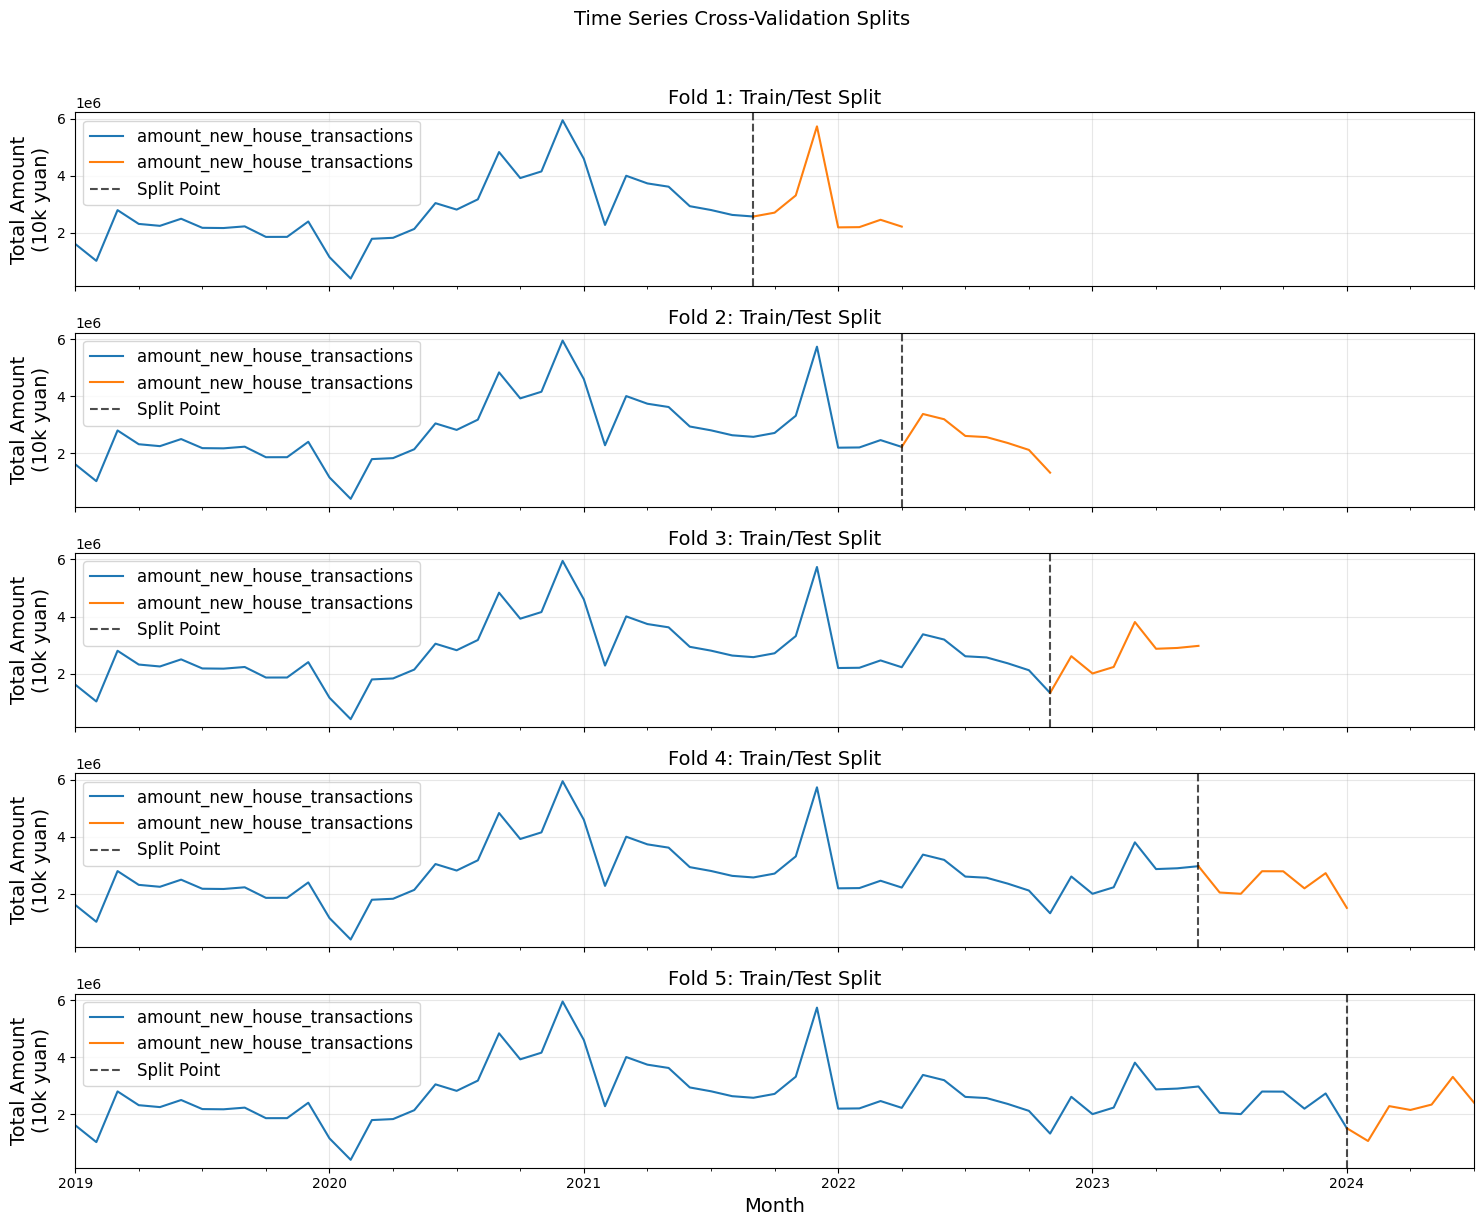


SPLIT STATISTICS

Fold 1:
  Train mean: 33,885
  Test mean:  38,492
  Difference: +13.6%

Fold 2:
  Train mean: 34,718
  Test mean:  31,281
  Difference: -9.9%

Fold 3:
  Train mean: 34,192
  Test mean:  31,237
  Difference: -8.6%

Fold 4:
  Train mean: 33,799
  Test mean:  29,970
  Difference: -11.3%

Fold 5:
  Train mean: 33,350
  Test mean:  26,080
  Difference: -21.8%


In [19]:
# ==========================================
# 4.2 VISUALIZE CROSS-VALIDATION SPLITS
# ==========================================

# Since we have multiple sectors, let's aggregate by month for visualization
monthly_target = df.groupby('month')[target_col].sum().reset_index()
monthly_target = monthly_target.set_index('month').sort_index()

# Create figure
fig, axes = plt.subplots(5, 1, figsize=(15, 12), sharex=True)
fig.suptitle('Time Series Cross-Validation Splits', fontsize=14, y=1.02)

# Plot each fold
fold = 0
for train_idx, test_idx in tscv.split(X):
    # Get train/test months
    train_months = df.iloc[train_idx]['month'].unique()
    test_months = df.iloc[test_idx]['month'].unique()
    
    # Filter monthly aggregated data
    train_data = monthly_target[monthly_target.index.isin(train_months)]
    test_data = monthly_target[monthly_target.index.isin(test_months)]
    
    # Plot
    train_data.plot(ax=axes[fold], 
                    label='Training Set',
                    color='#1f77b4',
                    title=f'Fold {fold+1}: Train/Test Split')
    test_data.plot(ax=axes[fold], 
                   label='Test Set',
                   color='#ff7f0e')
    
    # Add vertical line at split point
    axes[fold].axvline(test_data.index.min(), 
                       color='black', 
                       ls='--', 
                       alpha=0.7,
                       label='Split Point')
    
    # Format
    axes[fold].set_ylabel('Total Amount\n(10k yuan)')
    axes[fold].legend(loc='upper left')
    axes[fold].grid(True, alpha=0.3)
    
    fold += 1

axes[-1].set_xlabel('Month')
plt.tight_layout()
plt.show()

# Summary statistics
print("\n" + "="*40)
print("SPLIT STATISTICS")
print("="*40)
for i, (train_idx, test_idx) in enumerate(tscv.split(X)):
    train_y = y.iloc[train_idx]
    test_y = y.iloc[test_idx]
    print(f"\nFold {i+1}:")
    print(f"  Train mean: {train_y.mean():,.0f}")
    print(f"  Test mean:  {test_y.mean():,.0f}")
    print(f"  Difference: {(test_y.mean() - train_y.mean())/train_y.mean()*100:+.1f}%")

# 4. MODELING - XGBoost and Visualisations

In [20]:
# ==========================================
# 5. XGBOOST MODELING WITH CROSS-VALIDATION
# ==========================================

# Define features and target
target_col = 'amount_new_house_transactions'
non_features = ['month', 'date', 'sector', target_col]
feature_cols = [col for col in df.columns if col not in non_features]

print(f"Features: {len(feature_cols)}")
print(f"Target: {target_col}")

# Storage for results
fold = 0
preds = []
scores = []
models = []

for train_idx, test_idx in tscv.split(df):
    print(f"\n--- Fold {fold + 1} ---")
    
    # Split data
    train = df.iloc[train_idx]
    test = df.iloc[test_idx]
    
    # Prepare X and y
    X_train = train[feature_cols]
    y_train = train[target_col]
    X_test = test[feature_cols]
    y_test = test[target_col]
    
    # Handle NaN in target
    train_mask = ~y_train.isna()
    test_mask = ~y_test.isna()
    
    X_train = X_train[train_mask]
    y_train = y_train[train_mask]
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]
    
    print(f"Train: {len(X_train)} | Test: {len(X_test)}")
    
    # XGBoost model
    reg = xgb.XGBRegressor(
        n_estimators=500,
        max_depth=5,
        learning_rate=0.01,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        early_stopping_rounds=50
    )
    
    # Train
    reg.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100
    )
    
    # Predict
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    
    # Score
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    models.append(reg)
    
    print(f"RMSE: {score:,.0f}")
    fold += 1

# Summary
print("\n" + "="*40)
print(f"Average RMSE: {np.mean(scores):,.0f}")
print(f"Std RMSE: {np.std(scores):,.0f}")

Features: 46
Target: amount_new_house_transactions

--- Fold 1 ---
Train: 2583 | Test: 570
[0]	validation_0-rmse:53760.47734	validation_1-rmse:57234.68517
[100]	validation_0-rmse:23764.92888	validation_1-rmse:35221.82939
[200]	validation_0-rmse:11670.13318	validation_1-rmse:27034.67292
[300]	validation_0-rmse:6559.35873	validation_1-rmse:23002.32108
[400]	validation_0-rmse:4310.67838	validation_1-rmse:20853.16360
[499]	validation_0-rmse:3237.91430	validation_1-rmse:19897.11196
RMSE: 19,897

--- Fold 2 ---
Train: 3153 | Test: 570
[0]	validation_0-rmse:54378.69621	validation_1-rmse:41162.62384
[100]	validation_0-rmse:24421.82493	validation_1-rmse:24852.40513
[200]	validation_0-rmse:12079.01313	validation_1-rmse:19791.97281
[300]	validation_0-rmse:6724.37721	validation_1-rmse:17914.84421
[400]	validation_0-rmse:4334.96508	validation_1-rmse:17120.43926
[499]	validation_0-rmse:3199.57149	validation_1-rmse:16689.05391
RMSE: 16,689

--- Fold 3 ---
Train: 3723 | Test: 570
[0]	validation_0-rmse

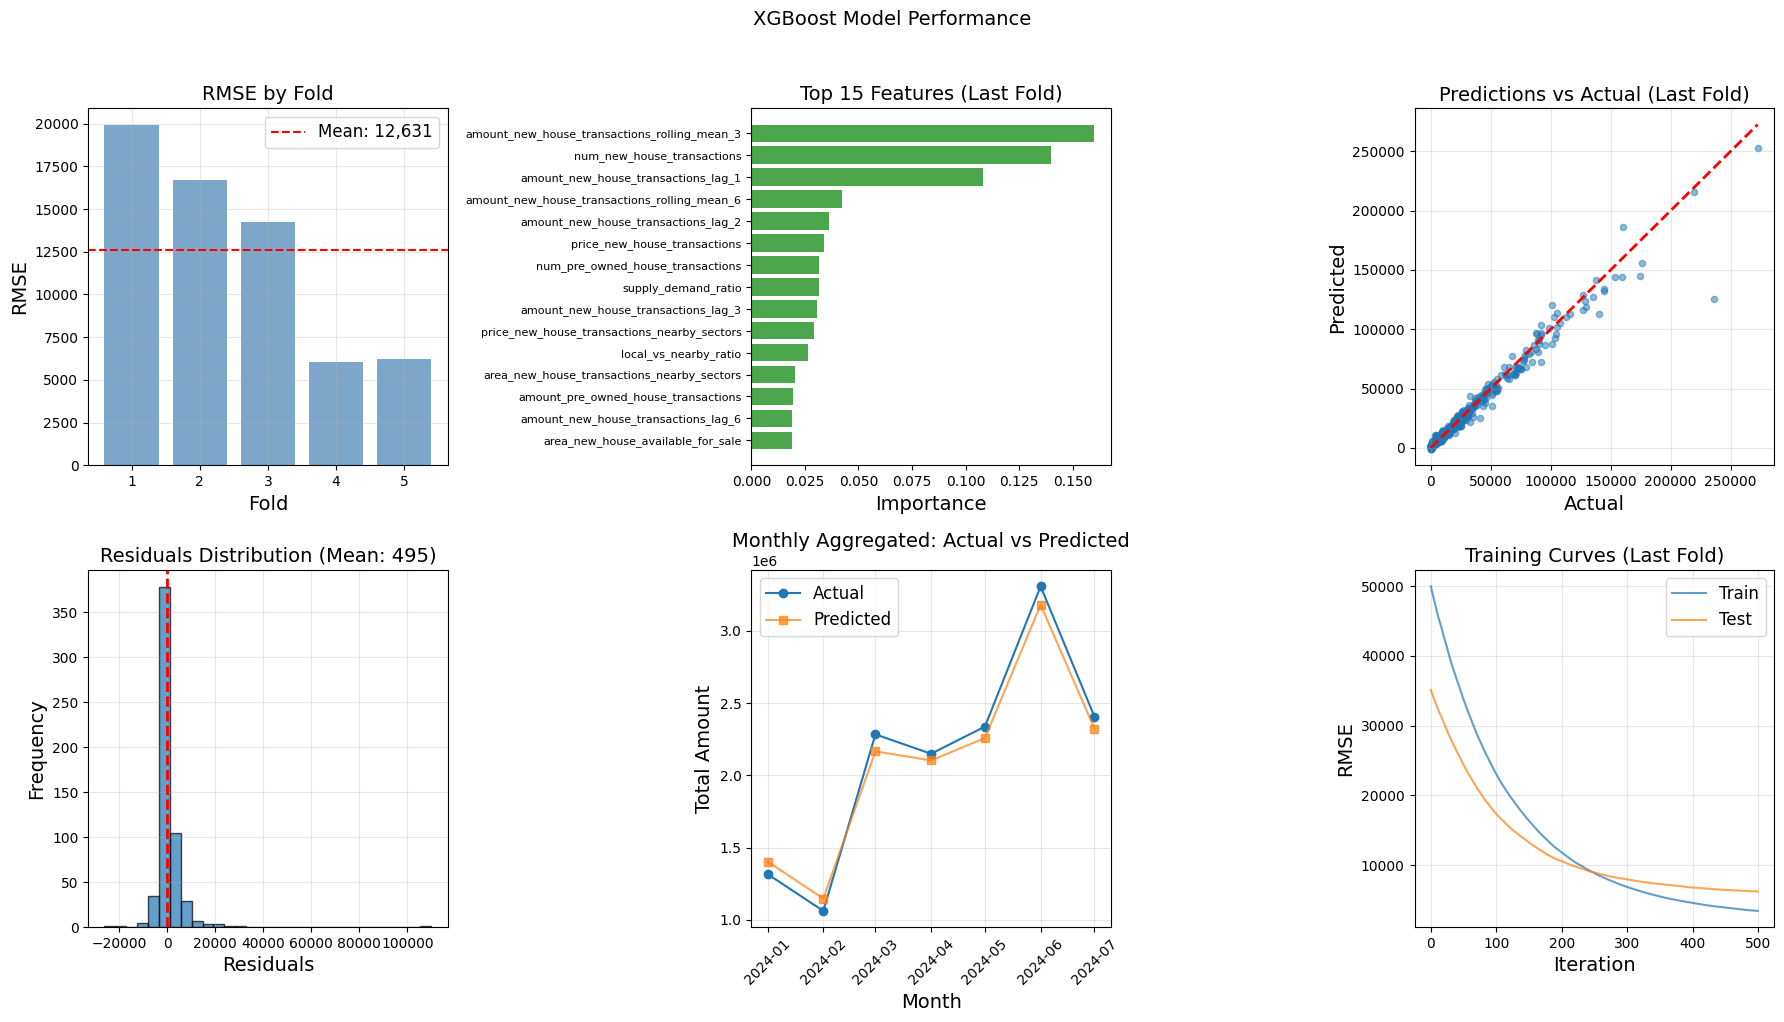


PERFORMANCE SUMMARY
Average RMSE: 12,631
Best Fold: 4 (RMSE: 6,068)
Worst Fold: 1 (RMSE: 19,897)
Standard Deviation: 5,581


In [21]:
# ==========================================
# 6. VISUALIZATION OF RESULTS
# ==========================================

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# 1. RMSE across folds
axes[0, 0].bar(range(1, len(scores)+1), scores, color='steelblue', alpha=0.7)
axes[0, 0].axhline(np.mean(scores), color='red', linestyle='--', label=f'Mean: {np.mean(scores):,.0f}')
axes[0, 0].set_xlabel('Fold')
axes[0, 0].set_ylabel('RMSE')
axes[0, 0].set_title('RMSE by Fold')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Feature importance (from last model)
last_model = models[-1]
importances = last_model.feature_importances_
indices = np.argsort(importances)[::-1][:15]  # Top 15

axes[0, 1].barh(range(15), importances[indices], color='green', alpha=0.7)
axes[0, 1].set_yticks(range(15))
axes[0, 1].set_yticklabels([feature_cols[i] for i in indices], fontsize=8)
axes[0, 1].set_xlabel('Importance')
axes[0, 1].set_title('Top 15 Features (Last Fold)')
axes[0, 1].invert_yaxis()

# 3. Predictions vs Actual (last fold)
# Get last fold data
last_test_idx = list(tscv.split(df))[-1][1]
last_test = df.iloc[last_test_idx]
X_last = last_test[feature_cols]
y_last = last_test[target_col]
test_mask = ~y_last.isna()
y_true = y_last[test_mask]
y_pred = preds[-1]

axes[0, 2].scatter(y_true, y_pred, alpha=0.5, s=20)
axes[0, 2].plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--', lw=2)
axes[0, 2].set_xlabel('Actual')
axes[0, 2].set_ylabel('Predicted')
axes[0, 2].set_title('Predictions vs Actual (Last Fold)')
axes[0, 2].grid(True, alpha=0.3)

# 4. Residuals
residuals = y_true - y_pred
axes[1, 0].hist(residuals, bins=30, edgecolor='black', alpha=0.7)
axes[1, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[1, 0].set_xlabel('Residuals')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].set_title(f'Residuals Distribution (Mean: {np.mean(residuals):,.0f})')
axes[1, 0].grid(True, alpha=0.3)

# 5. Predictions over time (last fold)
test_with_pred = last_test[test_mask].copy()
test_with_pred['predictions'] = y_pred
monthly_actual = test_with_pred.groupby('month')[target_col].sum()
monthly_pred = test_with_pred.groupby('month')['predictions'].sum()

axes[1, 1].plot(monthly_actual.index, monthly_actual.values, label='Actual', marker='o')
axes[1, 1].plot(monthly_pred.index, monthly_pred.values, label='Predicted', marker='s', alpha=0.7)
axes[1, 1].set_xlabel('Month')
axes[1, 1].set_ylabel('Total Amount')
axes[1, 1].set_title('Monthly Aggregated: Actual vs Predicted')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].tick_params(axis='x', rotation=45)

# 6. Learning curves (last model)
results = last_model.evals_result()
axes[1, 2].plot(results['validation_0']['rmse'], label='Train', alpha=0.7)
axes[1, 2].plot(results['validation_1']['rmse'], label='Test', alpha=0.7)
axes[1, 2].set_xlabel('Iteration')
axes[1, 2].set_ylabel('RMSE')
axes[1, 2].set_title('Training Curves (Last Fold)')
axes[1, 2].legend()
axes[1, 2].grid(True, alpha=0.3)

plt.suptitle('XGBoost Model Performance', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# Print performance summary
print("\n" + "="*50)
print("PERFORMANCE SUMMARY")
print("="*50)
print(f"Average RMSE: {np.mean(scores):,.0f}")
print(f"Best Fold: {np.argmin(scores) + 1} (RMSE: {np.min(scores):,.0f})")
print(f"Worst Fold: {np.argmax(scores) + 1} (RMSE: {np.max(scores):,.0f})")
print(f"Standard Deviation: {np.std(scores):,.0f}")

# 5. PREDICTING THE FUTURE
Retraining on all data

To Predict the future we need an emtpy dataframe for future date ranges.

Run those dates through our feature creation code + lag creation

In [ ]:
# ------------------------------------------
# 6.1 Load and Decode Submission Template
# ------------------------------------------

submission_template = pd.read_csv("/Users/nikola/Python/KaggleCompetition/data/sample_submission.csv")
print(f"Submission shape: {submission_template.shape}")
print(f"Sample IDs: {submission_template['id'].head()}")

# Parse the ID format: "2024 Aug_sector 1"
submission_template['year'] = submission_template['id'].str.split(' ').str[0].astype(int)
submission_template['month_abbr'] = submission_template['id'].str.split('_').str[0].str.split(' ').str[1]
submission_template['sector'] = submission_template['id'].str.split('_').str[1]

# Create proper datetime from year and month abbreviation
submission_template['month'] = pd.to_datetime(
    submission_template['year'].astype(str) + ' ' + submission_template['month_abbr'],
    format='%Y %b'
)

print(f"\nParsed submission data:")
print(submission_template[['id', 'month', 'sector']].head())

# ------------------------------------------
# 6.2 Prepare Combined Dataset
# ------------------------------------------

print(f"\nSubmission date range: {submission_template['month'].min()} to {submission_template['month'].max()}")
print(f"Unique sectors: {submission_template['sector'].nunique()}")
print(f"Unique months: {submission_template['month'].nunique()}")

# Combine historical with submission requirements
combined_df = pd.concat([
    df,  # Historical data
    submission_template[['month', 'sector']]  # Future to predict
], ignore_index=True)

# Remove duplicates and sort
combined_df = combined_df.drop_duplicates(subset=['month', 'sector'])
combined_df = combined_df.sort_values(['sector', 'month']).reset_index(drop=True)

print(f"Combined shape: {combined_df.shape}")

# ------------------------------------------
# 6.3 Create Features
# ------------------------------------------

print("\nCreating features...")

# Time features
combined_df['year'] = combined_df['month'].dt.year
combined_df['month_num'] = combined_df['month'].dt.month
combined_df['quarter'] = combined_df['month'].dt.quarter
combined_df['month_sin'] = np.sin(2 * np.pi * combined_df['month_num'] / 12)
combined_df['month_cos'] = np.cos(2 * np.pi * combined_df['month_num'] / 12)

# Lag features
for lag in [1, 2, 3, 6, 12]:
    combined_df[f'{target_col}_lag_{lag}'] = (
        combined_df.groupby('sector')[target_col].shift(lag)
    )

# Rolling features
for window in [3, 6, 12]:
    combined_df[f'{target_col}_rolling_mean_{window}'] = (
        combined_df.groupby('sector')[target_col]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).mean())
    )
    combined_df[f'{target_col}_rolling_std_{window}'] = (
        combined_df.groupby('sector')[target_col]
        .transform(lambda x: x.shift(1).rolling(window, min_periods=1).std())
    )

# Forward fill other features
for col in feature_cols:
    if col in combined_df.columns:
        combined_df[col] = combined_df.groupby('sector')[col].ffill()

# ------------------------------------------
# 6.4 Train Final Model
# ------------------------------------------

# Get training data (where target is not null)
train_mask = ~combined_df[target_col].isna()
X_train = combined_df[train_mask][feature_cols]
y_train = combined_df[train_mask][target_col]

print(f"\nTraining on {len(X_train)} samples...")

final_model = xgb.XGBRegressor(
    n_estimators=500,
    max_depth=5,
    learning_rate=0.01,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

final_model.fit(X_train, y_train, verbose=100)

# ------------------------------------------
# 6.5 Make Predictions
# ------------------------------------------

print("\nMaking predictions...")

# Merge submission with combined_df to get features
submission_with_features = submission_template[['id', 'month', 'sector']].merge(
    combined_df,
    on=['month', 'sector'],
    how='left'
)

# Get features for prediction
X_submission = submission_with_features[feature_cols]

# Handle any missing features
X_submission = X_submission.fillna(0)

# Predict
predictions = final_model.predict(X_submission)

CREATING SUBMISSION FILE
Submission shape: (1152, 2)
Sample IDs: 0    2024 Aug_sector 1
1    2024 Aug_sector 2
2    2024 Aug_sector 3
3    2024 Aug_sector 4
4    2024 Aug_sector 5
Name: id, dtype: object

Parsed submission data:
                  id      month    sector
0  2024 Aug_sector 1 2024-08-01  sector 1
1  2024 Aug_sector 2 2024-08-01  sector 2
2  2024 Aug_sector 3 2024-08-01  sector 3
3  2024 Aug_sector 4 2024-08-01  sector 4
4  2024 Aug_sector 5 2024-08-01  sector 5

Submission date range: 2024-08-01 00:00:00 to 2025-07-01 00:00:00
Unique sectors: 96
Unique months: 12
Combined shape: (6585, 50)

Creating features...

Training on 5433 samples...

Making predictions...

Final submission:
                  id  new_house_transaction_amount
0  2024 Aug_sector 1                   8234.620117
1  2024 Aug_sector 2                   3004.431885
2  2024 Aug_sector 3                   4336.283203
3  2024 Aug_sector 4                  83794.828125
4  2024 Aug_sector 5                    

# 6. SAVE TO THE SAMPLE SUBMISSION

In [ ]:
# ------------------------------------------
# 7.1 Create Final Submission
# ------------------------------------------

submission = pd.DataFrame({
    'id': submission_template['id'],
    'new_house_transaction_amount': predictions
})

print(f"\nFinal submission:")
print(submission.head())

# Save
output_path = Path("/Users/nikola/Python/KaggleCompetition/output/03_First_Submission_XGBoost")
submission.to_csv(output_path / "submission.csv", index=False)
print(f"\nSaved to: {output_path / 'submission.csv'}")

# Verify
print(f"\n✓ Rows: {len(submission)} (expected: 1152)")
print(f"✓ Missing: {submission['new_house_transaction_amount'].isna().sum()}")
print(f"✓ Range: {submission['new_house_transaction_amount'].min():.0f} to {submission['new_house_transaction_amount'].max():.0f}")

VISUALIZING PREDICTIONS


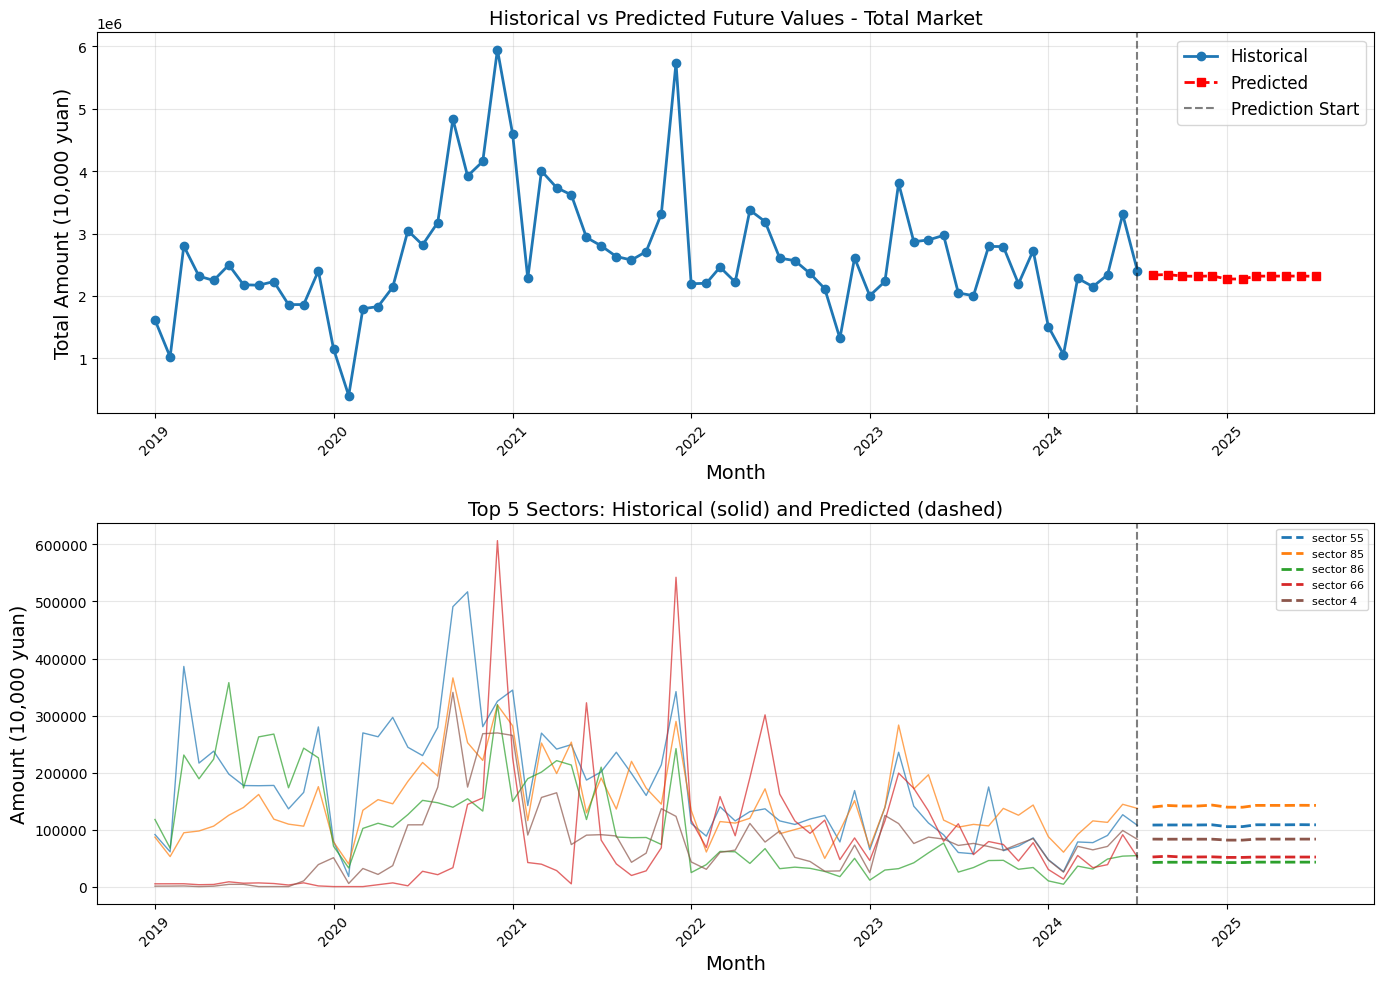


PREDICTION SUMMARY

Historical last 3 months avg: 2,684,372
Predicted next 3 months avg: 2,333,090
Expected growth rate: -13.1%

Top sectors predicted growth:
  sector 55: +28.6%
  sector 85: +23.8%
  sector 86: +19.8%


In [ ]:
# ==========================================
# 7.2 VISUALIZE PREDICTIONS
# ==========================================

import matplotlib.pyplot as plt

print("="*60)
print("VISUALIZING PREDICTIONS")
print("="*60)

# Get historical data and predictions
last_historical_month = df['month'].max()
historical_data = combined_df[combined_df['month'] <= last_historical_month].copy()
future_data = submission_with_features.copy()
future_data['predicted_amount'] = predictions

fig, axes = plt.subplots(2, 1, figsize=(14, 10))

# ------------------------------------------
# Plot 1: Total monthly amounts
# ------------------------------------------

# Historical totals
historical_monthly = historical_data.groupby('month')[target_col].sum()

# Future predictions totals
future_monthly = future_data.groupby('month')['predicted_amount'].sum()

# Plot
axes[0].plot(historical_monthly.index, historical_monthly.values, 
             label='Historical', marker='o', linewidth=2, color='#1f77b4')
axes[0].plot(future_monthly.index, future_monthly.values, 
             label='Predicted', marker='s', linewidth=2, linestyle='--', color='red')
axes[0].axvline(last_historical_month, color='black', linestyle='--', alpha=0.5, label='Prediction Start')
axes[0].set_xlabel('Month')
axes[0].set_ylabel('Total Amount (10,000 yuan)')
axes[0].set_title('Historical vs Predicted Future Values - Total Market')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Format x-axis
axes[0].tick_params(axis='x', rotation=45)

# ------------------------------------------
# Plot 2: Top 5 sectors
# ------------------------------------------

# Find top 5 sectors by historical volume
top_sectors = historical_data.groupby('sector')[target_col].sum().nlargest(5).index

colors = plt.cm.tab10(np.linspace(0, 0.5, 5))

for i, sector in enumerate(top_sectors):
    # Historical data for this sector
    sector_hist = historical_data[historical_data['sector'] == sector].groupby('month')[target_col].sum()
    
    # Future predictions for this sector
    sector_future = future_data[future_data['sector'] == sector].groupby('month')['predicted_amount'].sum()
    
    # Plot historical as solid line
    axes[1].plot(sector_hist.index, sector_hist.values, 
                 alpha=0.7, linewidth=1, color=colors[i])
    
    # Plot predictions as dashed line
    axes[1].plot(sector_future.index, sector_future.values, 
                 linestyle='--', linewidth=2, color=colors[i], 
                 label=f'{sector[:30]}...' if len(sector) > 30 else sector)

# Add vertical line at prediction start
axes[1].axvline(last_historical_month, color='black', linestyle='--', alpha=0.5)
axes[1].set_xlabel('Month')
axes[1].set_ylabel('Amount (10,000 yuan)')
axes[1].set_title('Top 5 Sectors: Historical (solid) and Predicted (dashed)')
axes[1].legend(fontsize=8, loc='best')
axes[1].grid(True, alpha=0.3)
axes[1].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

# ------------------------------------------
# Summary Statistics
# ------------------------------------------

print("\n" + "="*40)
print("PREDICTION SUMMARY")
print("="*40)

# Monthly growth
hist_last_3_months = historical_monthly.tail(3).mean()
pred_first_3_months = future_monthly.head(3).mean()
growth_rate = (pred_first_3_months - hist_last_3_months) / hist_last_3_months * 100

print(f"\nHistorical last 3 months avg: {hist_last_3_months:,.0f}")
print(f"Predicted next 3 months avg: {pred_first_3_months:,.0f}")
print(f"Expected growth rate: {growth_rate:+.1f}%")

# Sector predictions
print("\nTop sectors predicted growth:")
for sector in top_sectors[:3]:
    hist_avg = historical_data[historical_data['sector'] == sector][target_col].tail(12).mean()
    pred_avg = future_data[future_data['sector'] == sector]['predicted_amount'].mean()
    growth = (pred_avg - hist_avg) / hist_avg * 100 if hist_avg > 0 else 0
    print(f"  {sector[:40]}: {growth:+.1f}%")